In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy
import statsmodels.stats.api as sms
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_white
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.arima import auto_arima

The aim of the project will be to analyze credit liabilities of households in Canada in the years 2021-2023. We will analyze liabilities resulting from non-mortgage loans. The data was downloaded from the <a href="https://www.statcan.gc.ca/fr/debut">Statistique Canada</a> portal, where data on the realities of life in Canada on many levels was made available. We will deal with the following:
 <ul>
     <li>General outline of the problem</li>
     <li>Decomposition of the series</li>
     <li>Proper selection of the first model</li>
     <li>Modeling residuals</li>
     <li>Proper selection of the second model</li>
     <li>Comparison of both models</li>
     <li>Prediction</li>

## General outline of the problem

In [2]:
kanada = pd.read_csv("kanada.csv")
kanada.Date = kanada.Date.astype('datetime64[ns]')

kredyty_nieh = kanada[kanada['Credit liabilities of households'] == "Non-mortgage loans"].drop('Credit liabilities of households', axis=1)
kredyty_nieh['Date'] = pd.to_datetime(kredyty_nieh['Date']) 


karta_kred = kanada[kanada['Credit liabilities of households'] == "Credit cards"].drop('Credit liabilities of households', axis=1)
karta_kred = karta_kred.set_index('Date')

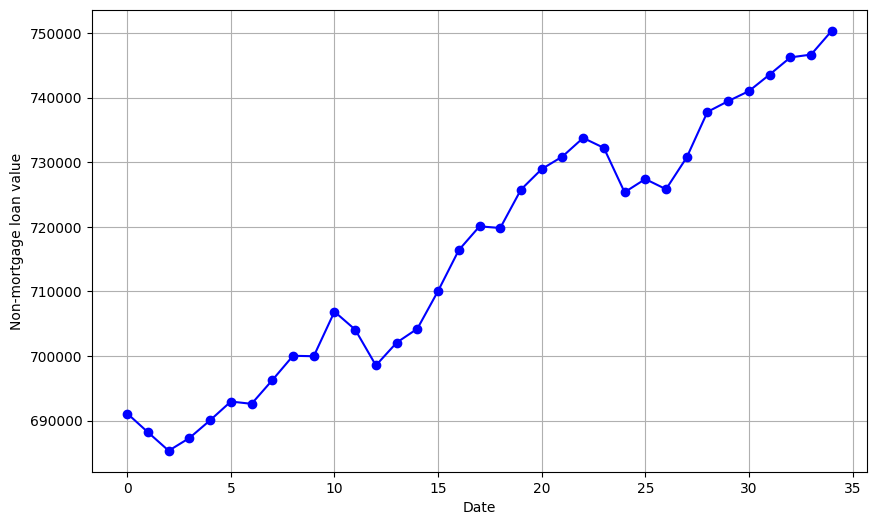

In [3]:
#| label: fig-overview
#| fig-cap: Distribution of the average amount of non-mortgage loans taken in Canada

plt.figure(figsize=(10, 6))
plt.plot(kredyty_nieh.index, kredyty_nieh['VALUE'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Non-mortgage loan value')
plt.grid(True)
plt.show()

The above chart (see @fig-overview) shows that with almost every month, the value of Canadians’ obligations to banks through non-mortgage loans increased. Assuming that the average value of the loan in January 2021 was about 690,000 CAD, while at the end of the analyzed period falling on December 2023 it is already about 750,000 CAD. This means that the average percentage increase in household debt in Canada in the given period is about:

In [4]:
str(round(750000/690000 * 100 - 100, 2)) + "%"

'8.7%'

The chart below (@fig-boxplot1) vividly illustrates how quickly the bank liabilities of the average Canadian household grew over the years 2021-2023.

In [5]:
a = kredyty_nieh.copy()
a["year"] = a.Date.dt.year
a["month"] = a.Date.dt.month

<Figure size 1200x600 with 0 Axes>

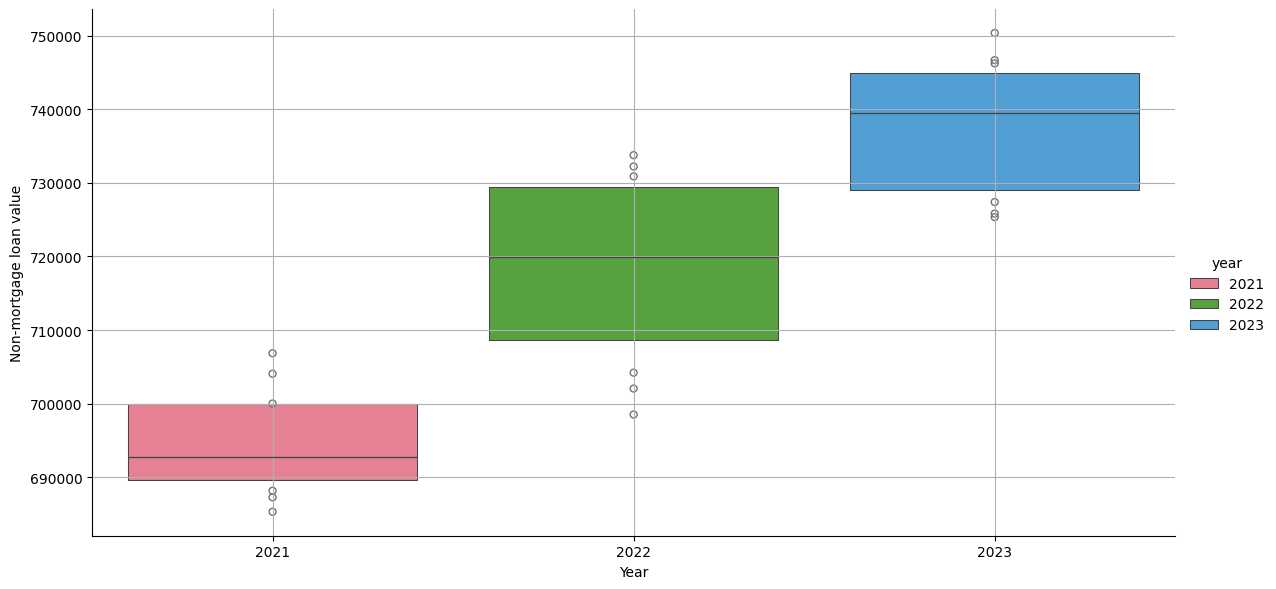

In [6]:
#| label: fig-boxplot1
#| fig-cap: Boxplot of non-mortgage loan value by year

custom_palette = sns.color_palette("husl", 3) 

plt.figure(figsize=(12, 6))
sns.catplot(data=a, x="year", y="VALUE", hue="year", kind="boxen", palette=custom_palette, height=6, aspect=2)
plt.xlabel('Year')
plt.ylabel('Non-mortgage loan value')
plt.grid(True)
plt.show()

Let’s look at how the demand for non-mortgage loans was divided into individual months:

c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


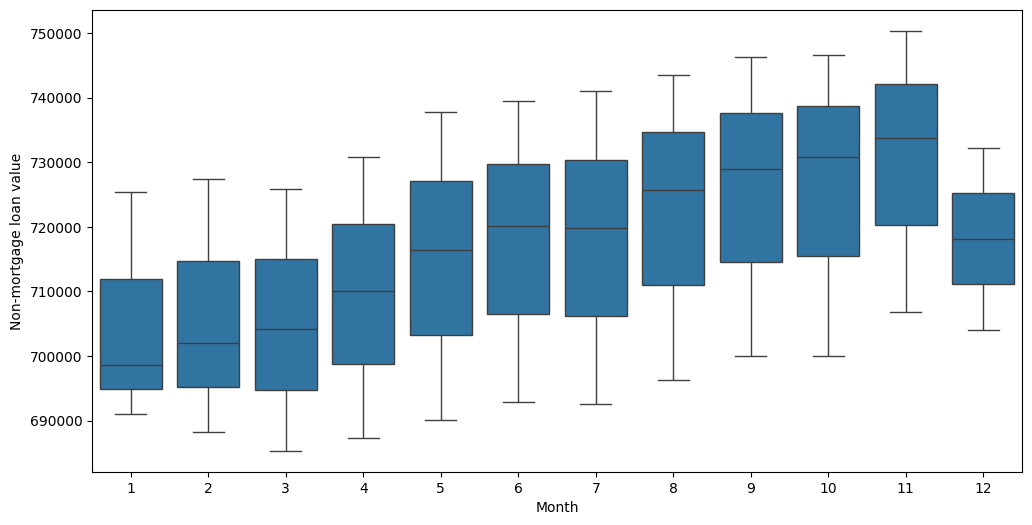

In [7]:
#| label: fig-boxplot2
#| fig-cap: Boxplot for the sum of non-mortgage loans by month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='VALUE', data=a)
plt.xlabel('Month')
plt.ylabel('Non-mortgage loan value')
plt.show()

We notice that on average throughout the year, the tendency to take out larger loans is positive, except for December, when the average value of the loan taken out breaks out of the trend and is significantly lower than the value from the previous month. It might seem that it is in the Christmas period that the credit peak of the year occurs, especially in the Western world, where consumerism is ubiquitous.

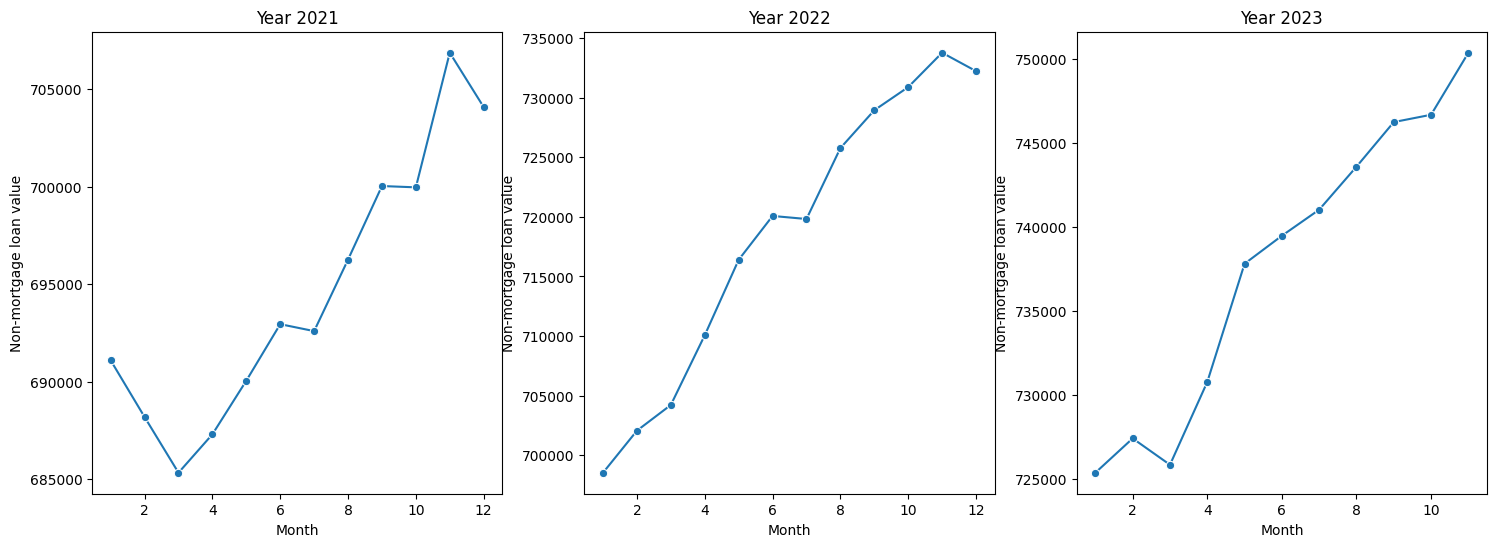

In [8]:
#| label: fig-linearity
#| fig-cap: Linear chart by year

plt.figure(figsize=(18, 6))

years = a['year'].unique()
for i, year in enumerate(years, 1):
    plt.subplot(1, len(years), i)
    data_year = a[a['year'] == year]
    sns.lineplot(x='month', y='VALUE', data=data_year, marker='o')
    plt.title(f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Non-mortgage loan value')


plt.show()

We identify this phenomenon more deeply on the above charts (@fig-linearity). As for December 2023, it is not included in the data, probably the Canadian statistical office has not yet completed the report for this month.

The table below presents basic descriptive statistics for the discussed data set, by year. In line with the previous assumptions of the upward trend with subsequent months, the mean for each year is higher than for the previous one. The same is true for the value of the standard deviation, we observe a deviation in the case of the value of this statistic for 2022, where it reaches the maximum value. The interpretation may be as follows: in 2022, the market may have been uncertain due to certain events in the country / in the world, which is why the deviations from the mean value for this year were the largest.

In [9]:
grouped_data = a.groupby('year')['VALUE']
mean_values = round(grouped_data.mean(),2)
std_values = round(grouped_data.std(),2)

# Tworzenie tabelki
result_table = pd.DataFrame({
    'Year': mean_values.index,
    'Mean': mean_values.values,
    'Standard deviation': std_values.values
})
result_table

,Year,Mean,Standard deviation
0,2021,694562.67,6882.13
1,2022,718558.92,12384.76
2,2023,737666.55,8997.32


## Series decomposition

Series decomposition into its individual components: trend, seasonality and noise, will allow to examine its properties more closely.

In [10]:
b = kredyty_nieh.copy()
b = b.set_index('Date')

Trend plot:

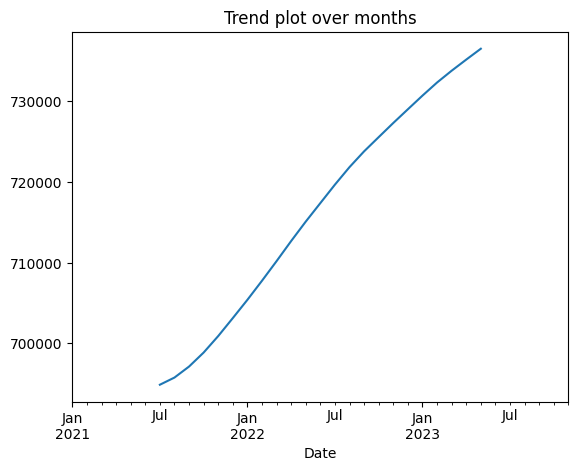

In [11]:
trend_kredyty_nieh = seasonal_decompose(b, period = 12).trend

trend_kredyty_nieh.plot()
plt.title("Trend plot over months")
plt.show()

We notice a clear, large tendency to increase the value of non-mortgage loans per household over the years discussed.

Seasonality plot:

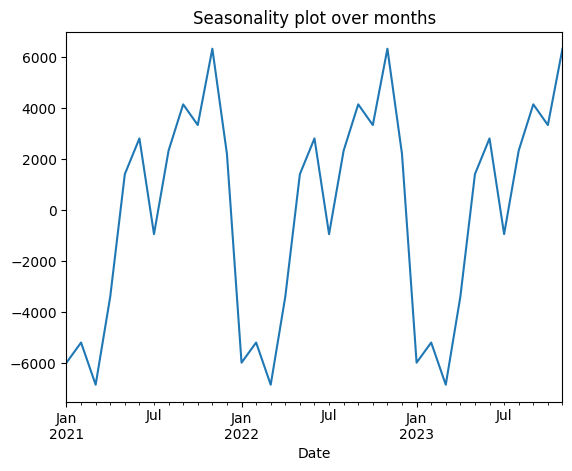

In [12]:
sezon_kredyty_nieh = seasonal_decompose(b, period = 12).seasonal

sezon_kredyty_nieh.plot()
plt.title("Seasonality plot over months")
plt.show()

Na powyższym wykresie identyfikujemy roczną sezonowość omawianego szeregu. Oznacza to, że w skali roku zmienne przyjmują podobne wartości.

Residual plots:

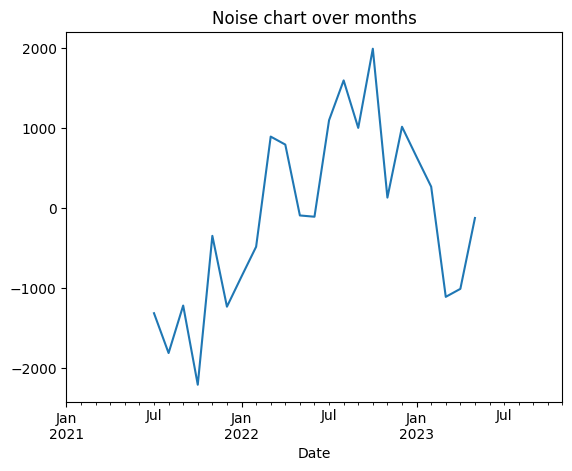

In [13]:
reszty_kredyty_nieh = seasonal_decompose(b, period = 12).resid

reszty_kredyty_nieh.plot()
plt.title("Noise chart over months")
plt.show()

Noise is treated as an element that is difficult to predict and control.

## Selection of the first model

Due to the annual seasonality of the data, we can build the first model - the Holt-Winters model.

c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\spoko\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


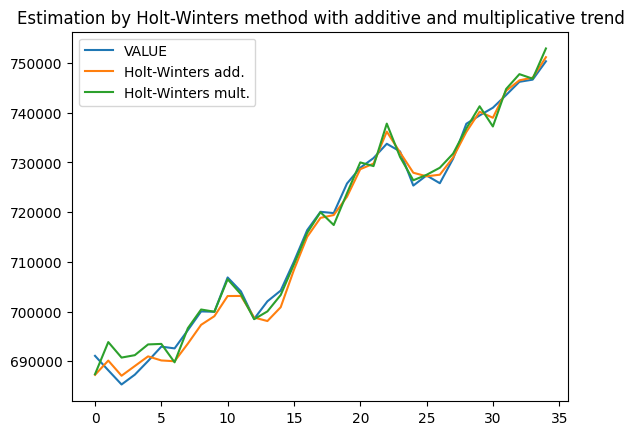

In [14]:
#| label: fig-holt
#| fig-cap: Holt-Winters method

mdl_holt_mul = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit()
mdl_holt_add = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit()

kredyty_nieh['Holt-Winters add.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='add', seasonal_periods = 12, seasonal = "add").fit().fittedvalues
kredyty_nieh['Holt-Winters mult.'] = ExponentialSmoothing(kredyty_nieh['VALUE'],trend='mul', seasonal_periods = 12, seasonal = "mul").fit().fittedvalues
kredyty_nieh[['VALUE','Holt-Winters add.','Holt-Winters mult.']].plot(title="Estimation by Holt-Winters method with additive and multiplicative trend")
plt.show()

We will present on the chart how the Holt-Winters method estimates the analyzed series (@fig-holt). We observe a relatively good fit to the theoretical data. The charts for the additive and multiplicative trends differ slightly from each other. We choose the better model based on the lower value of the AIC index.

The value of the AIC index of the additive model:

In [15]:
round(mdl_holt_add.aic,2)

563.15

The value of the AIC index of the multiplicative model:

In [16]:
round(mdl_holt_mul.aic,2)

574.4

The model with the additive trend turns out to be slightly better than the multiplicative model.

## Residual modeling

Initially, we perform an autocorrelation analysis of the residuals of the constructed model. We use the Durbin-Watson test. The value of the obtained statistic:

In [17]:
print("Durbin-Watson Test statistic: "+ str(durbin_watson(mdl_holt_add.resid)))

Durbin-Watson Test statistic: 1.2345091693407397


The values of the Durbin-Watson test statistic belong to the interval [0; 4]. It is assumed that if the value of the calculated test statistic is not from the interval [1.5; 2.5] then the autocorrelation is significant. We therefore assess that the residuals of the model are correlated.

We perform the Dickey-Fuller test to examine stationarity:

In [18]:
print("Dickey-Fuller Test p-value: "+str(adfuller(kredyty_nieh.VALUE)[1]))

Dickey-Fuller Test p-value: 0.8235560642084352


We have no grounds to reject the null hypothesis of no stationarity of the series -> the series is non-stationary.

We analyze the normality of the distribution of the residuals of the model. We perform the Shapiro-Wilk test:

In [19]:
print("Shaprio-Wilk Test p-value: "+str(scipy.stats.shapiro(mdl_holt_add.resid)[1]))

Shaprio-Wilk Test p-value: 0.3002574165625425


We have no grounds to reject the null hypothesis of normality of the distribution of the residuals of the model.

We examine the homogeneity of the residuals of the model by performing the Goldfeld-Quandt test. However, first we draw a plot of the standardized residuals of the model versus the fitted values, from which we can initially infer whether the condition of homogeneity of variance of the residuals is met.

In [20]:
#kredyty_nieh = kredyty_nieh.set_index(['Date']) 
residuals = mdl_holt_add.resid
std_residuals = residuals / np.std(residuals)

sqrt_std_residuals = np.sqrt(np.abs(std_residuals))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


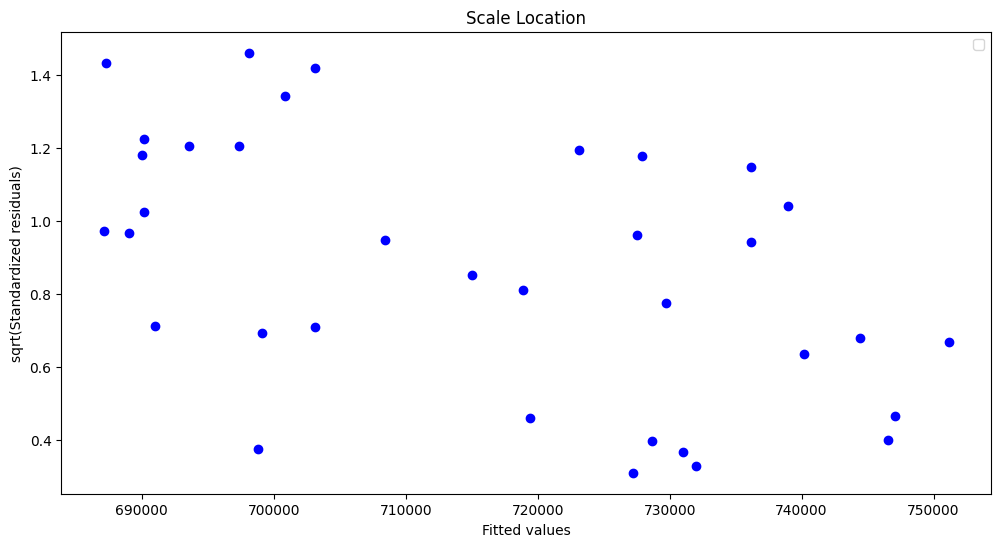

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(mdl_holt_add.fittedvalues, sqrt_std_residuals, marker='o', color='blue')
plt.xlabel('Fitted values')
plt.ylabel('sqrt(Standardized residuals)')
plt.title('Scale Location')

plt.legend()
plt.show()

We notice that they are distributed parallel to the X axis (the axis of fitted values). We can therefore conclude about the homoscedasticity of the residuals. We will support this thesis by basing the decision on the p-value of the aforementioned test:

In [22]:
mdl_holt_add.model.exog =  np.column_stack((np.ones_like(kredyty_nieh.VALUE), kredyty_nieh.VALUE))

print("Goldfeld-Quandt Test p-value: "+str(sms.het_goldfeldquandt(mdl_holt_add.resid, mdl_holt_add.model.exog)[1]))

Goldfeld-Quandt Test p-value: 0.8297103454084707


According to the initial assumption, we have no grounds to reject the hypothesis of homogeneity of variance of the residuals.

In summary. The residuals of the model are correlated, the series is non-stationary and exhibits seasonality on a yearly scale. The appropriate forecasting model will be the SARIMA model. This model takes seven parameters (p,d,q)(P,D,Q)[s]. To estimate these parameters, we use the auto_arima() function, which creates different combinations of parameters p,d,q,P,D,Q for a given parameter s, indicating the period of seasonality, minimizing the AIC index at the same time. Summary of the constructed model:

In [23]:
model_sarima = auto_arima(kredyty_nieh.VALUE, 
                   seasonal=True, 
                   m=12, 
                   suppress_warnings=True,
                   error_action="ignore")

model_sarima = model_sarima.fit(kredyty_nieh.VALUE)

In [24]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -215.895
Date:                            Fri, 08 Mar 2024   AIC                            443.791
Time:                                    02:43:00   BIC                            450.604
Sample:                                         0   HQIC                           445.504
                                             - 35                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1918.2663   5768.997      0.333      0.740   -9388.760    1.32e+04
ar.L1          0.6088      0.122      4.972      0.000       0.369       0.849
ma.L1         -0.6243      0.118     -5.301      0.000      -0.855      -0.393
ar.S.L12       0.5592      0.539      1.038      0.299      -0.497       1.615
ma.S.L12      -0.5279      0.506     -1.044      0.296      -1.519       0.463
sigma2      4.209e+06     50.151   8.39e+04      0.000    4.21e+06    4.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.88   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.01   Prob(JB):                         0.71
Heteroskedasticity (H):               9.03   Skew:                             0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.77e+21. Standard errors may be unstable.
"""

We pay attention to the value of the AIC index of ~440.

We will now confront the constructed SARIMA model with the theoretical variables. We will try to predict how the sum of non-mortgage loans in Canadian households will increase/decrease. We will predict this for the next twenty-four months.

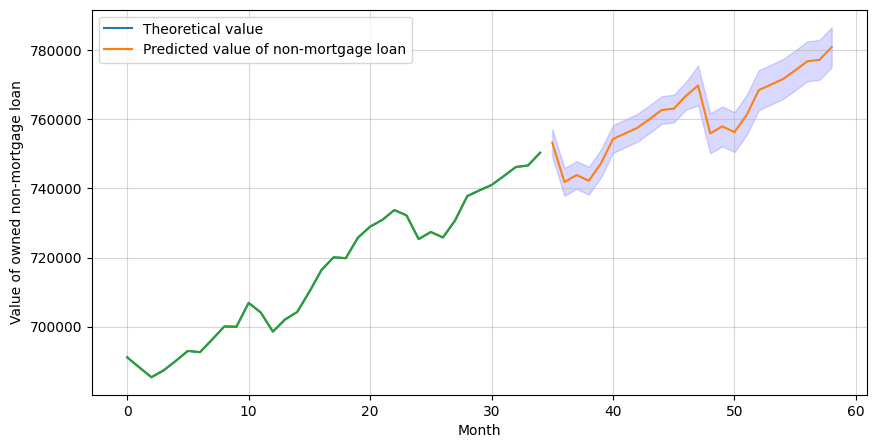

In [25]:
#| label: fig-sarima
#| fig-cap: SARIMA model prediction for next 24 months

forecast_auto, confidence_intervals_auto = model_sarima.predict(n_periods=24,
                                             return_conf_int=True)

ax = kredyty_nieh.VALUE[-12*4:].plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
kredyty_nieh.VALUE.plot(ax=ax)
plt.fill_between(forecast_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Theoretical value',
           'Predicted value of non-mortgage loan'], 
           loc='upper left')
plt.xlabel('Month')
plt.ylabel('Value of owned non-mortgage loan')
plt.grid(alpha=0.5)
plt.show()

As we observe on the above chart (@fig-sarima) we note the maintenance of the upward trend of the sum of non-mortgage credit. Confidence intervals have been plotted for the prediction on the chart.